In [15]:
#  Copyright (c) 2019 5GTANGO, Paderborn University
# ALL RIGHTS RESERVED.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#
# Neither the name of the SONATA-NFV, 5GTANGO, Paderborn University
# nor the names of its contributors may be used to endorse or promote
# products derived from this software without specific prior written
# permission.
#
# This work has also been performed in the framework of the 5GTANGO project,
# funded by the European Commission under Grant number 761493 through
# the Horizon 2020 and 5G-PPP programmes. The authors would like to
# acknowledge the contributions of their colleagues of the SONATA
# partner consortium (www.5gtango.eu).

In [16]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import seaborn as sns

# global plotting settings
plt.rcParams.update({'font.size': 20})

In [17]:
results_file = 'times_ns1_ns2_100runs.pkl'
df = pd.read_pickle(results_file)
df.head()

,instantiation,packaging,service,total,uploading
0,4.452872,0.693454,ns1,5.997273,0.850947
1,4.260494,0.677610,ns1,5.817075,0.878972
2,4.392053,0.759242,ns1,5.957409,0.806114
3,4.153521,1.093410,ns1,6.081639,0.834708
4,4.274660,0.639587,ns1,5.740244,0.825997


In [18]:
# stats for NS1 (to be used in deliverable)
df.loc[df['service'] == 'ns1'].describe()

,instantiation,packaging,total,uploading
count,100.000000,100.000000,100.000000,100.000000
mean,4.216072,0.698308,5.748794,0.834414
std,0.267551,0.114215,0.301710,0.048475
min,3.946852,0.566123,5.403324,0.690217
25%,4.095005,0.646104,5.599277,0.811133
50%,4.192135,0.667222,5.702172,0.839148
75%,4.256405,0.688641,5.808755,0.868672
max,6.416137,1.188443,7.939613,0.943620


In [19]:
# stats for NS2 (to be used in deliverable)
df.loc[df['service'] == 'ns2'].describe()

,instantiation,packaging,total,uploading
count,100.000000,100.000000,100.000000,100.000000
mean,3.373658,0.845942,4.859730,0.640130
std,0.111503,0.764819,0.788820,0.044986
min,3.143421,0.594045,4.430199,0.517326
25%,3.298025,0.655066,4.611915,0.612872
50%,3.361300,0.687628,4.701648,0.645345
75%,3.438527,0.789785,4.856213,0.676686
max,3.621489,6.103934,10.267015,0.728417


In [20]:
# get mean times for ns1 and ns2
pkg_avg = [df.loc[df['service'] == 'ns1']['packaging'].mean(), df.loc[df['service'] == 'ns2']['packaging'].mean()]
up_avg = [df.loc[df['service'] == 'ns1']['uploading'].mean(), df.loc[df['service'] == 'ns2']['uploading'].mean()]
inst_avg = [df.loc[df['service'] == 'ns1']['instantiation'].mean(), df.loc[df['service'] == 'ns2']['instantiation'].mean()]

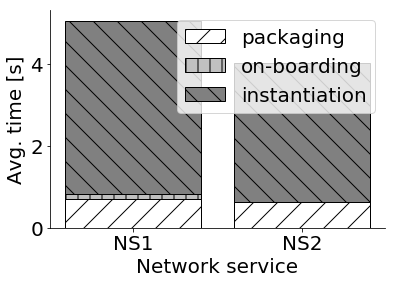

In [21]:
# plot stacked barplots with avg times per service
ns = [0, 1]
times = ['packaging', 'on-boarding', 'instantiation']

plt.bar(ns, pkg_avg, color='white', edgecolor='black', hatch='/')
plt.bar(ns, up_avg, bottom=pkg_avg, color='silver', edgecolor='black', hatch='|')
plt.bar(ns, inst_avg, bottom=up_avg, color='gray', edgecolor='black', hatch='\\')

plt.xticks(ns, ['NS1', 'NS2'])
plt.xlabel("Network service")
plt.ylabel("Avg. time [s]")
plt.legend(times)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('plots/barplot.pdf', bbox_inches='tight')
plt.show()

In [22]:
# plot CDF of times in specified column name
def plot_cdf(column_name, plot_name):
    ns1_times = df.loc[df['service'] == 'ns1'][column_name]
    ns2_times = df.loc[df['service'] == 'ns2'][column_name]
    num_times = ns1_times.shape[0]

    plt.hist(ns1_times, num_times, density=1, histtype='step', cumulative=True)
    plt.hist(ns2_times, num_times, density=1, histtype='step', cumulative=True)
    # drop at the end is an artifact of this hist plotting function

    plt.xlabel(f"{plot_name} times [s]")
    plt.ylabel("CDF")
    plt.legend(['NS1', 'NS2'], loc=4)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.savefig(f'plots/cdf_{column_name}.pdf', bbox_inches='tight')
    plt.show()

In [33]:
# nicer CDF plots
# from https://github.com/mpeuster/paper-ijnm-jouornal-sdn-handover/blob/master/evaluation/eval_packet_delay_cdf.ipynb

# calc and plot CDF (used within other function)
def calc_plot_cdf(sorted_list, bin_range, bins=1000, **kwargs):
    counts, bins = np.histogram(sorted_list, range=bin_range, bins=bins)
    cdf = np.cumsum(counts)/np.sum(counts)
    plt.plot(np.vstack((bins, np.roll(bins, -1))).T.flatten()[:-2], np.vstack((cdf, cdf)).T.flatten(), antialiased=True, lw=2, color='black', **kwargs)

def plot_nicer_cdf(column_name, plot_name, xlim=None, **kwargs):
    # select times for NS1 and NS2
    ns1_times = df.loc[df['service'] == 'ns1'][column_name]
    ns1_times_sortlist = np.sort(ns1_times.tolist())
    ns2_times = df.loc[df['service'] == 'ns2'][column_name]
    ns2_times_sortlist = np.sort(ns2_times.tolist())

    # calc and plot CDFs
    min_time = min(ns1_times_sortlist.min(), ns2_times_sortlist.min())
    max_time = max(ns1_times_sortlist.max(), ns2_times_sortlist.max())
    calc_plot_cdf(ns1_times_sortlist, [min_time, max_time], ls='-')    
    calc_plot_cdf(ns2_times_sortlist, [min_time, max_time], ls=':')
    
    # polish, save, and show plots
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    plt.ylim(0, 1)
    plt.xlabel(f"{plot_name} times [s]")
    plt.ylabel("CDF")
    plt.legend(['NS1', 'NS2'], loc=4)
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.savefig(f'plots/cdf_{column_name}.pdf', bbox_inches='tight')

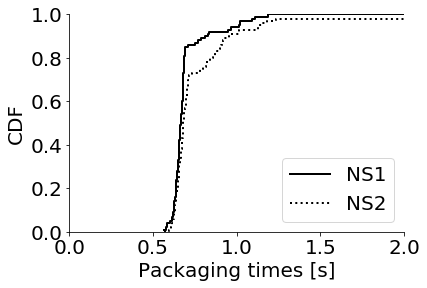

In [35]:
plot_nicer_cdf('packaging', 'Packaging', xlim=(0,2))

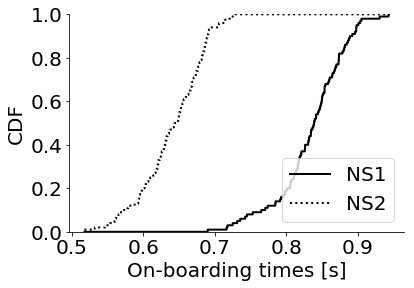

In [25]:
plot_nicer_cdf('uploading', 'On-boarding')

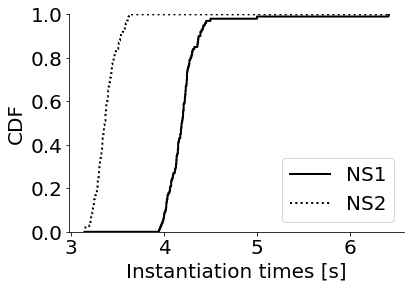

In [26]:
plot_nicer_cdf('instantiation', 'Instantiation')

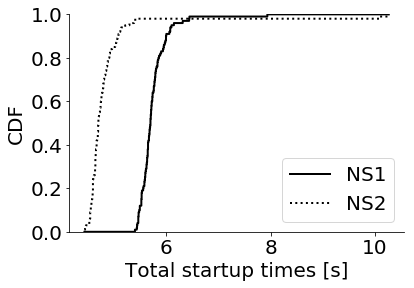

In [27]:
plot_nicer_cdf('total', 'Total startup')

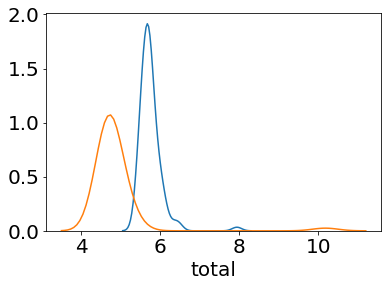

In [28]:
# histogram
ns1_times = df.loc[df['service'] == 'ns1']['total']
ns2_times = df.loc[df['service'] == 'ns2']['total']
sns.distplot(ns1_times, hist=False)
sns.distplot(ns2_times, hist=False)